In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import matplotlib.pyplot as plt
from umap import UMAP
import numpy as np
import pandas as pd
import torch

from counterfactuals.datasets import LawDataset
from counterfactuals.discriminative_models import (
    MultilayerPerceptron,
)

from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.plot_utils import (
    plot_classifier_decision_region,
    plot_generative_model_distribution,
    plot_observations,
    plot_counterfactuals,
    plot_arrows,
)
from counterfactuals.cf_methods import RPPCEF
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.metrics.metrics import evaluate_cf

torch.manual_seed(0)

In [72]:
def plot(
    ax, flow, disc_model, dataset, X_test, y_test, X_cf, prob_threshold, colors=None
):
    assert (
        X_test.shape == X_cf.shape
    ), f"Sizes of test set and counterfactuals are not equal. Actual sizes: X_test: {X_test.shape}, X_cf: {X_cf.shape}"
    assert (
        y_test.shape[0] == X_cf.shape[0]
    ), f"Sizes of targets and counterfactuals are not equal. Actual sizes: X_cf: {X_cf.shape}, y_test: {y_test.shape}"

    ax = plot_classifier_decision_region(ax, disc_model)
    ax = plot_generative_model_distribution(
        ax,
        flow,
        prob_threshold=prob_threshold,
        num_classes=len(np.unique(dataset.y_test)),
    )
    ax = plot_observations(ax, X_test, y_test, colors)
    ax = plot_counterfactuals(ax, X_cf)
    ax = plot_arrows(ax, X_test, X_cf)
    # ax = plot_metrics_textbox(ax, metrics)
    return ax

In [73]:
# dataset = HelocDataset(file_path="../data/heloc.csv")
dataset = LawDataset(file_path="../data/law.csv")

disc_model_name = "MultilayerPerceptron"
disc_model = MultilayerPerceptron(
    input_size=dataset.X_test.shape[1],
    hidden_layer_sizes=[256, 256],
    target_size=1,
)
# disc_model.fit(
#     dataset.train_dataloader(128, shuffle=True),
#     test_loader=dataset.test_dataloader(1024, shuffle=False),
#     epochs=1000,
#     lr=3e-4,
#     patience=100,
#     checkpoint_path="mlp.pth"
# )

disc_model.load(f"../models/LawDataset/disc_model_{disc_model_name}.pt")
# disc_model.load("mlp.pth")
disc_model.eval()
y_pred = disc_model.predict(dataset.X_test).numpy().flatten()
print(y_pred, dataset.y_test)
print(f"Accuracy: {np.mean(y_pred == dataset.y_test)}")


dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

flow = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=1,
)
# flow.fit(
#     dataset.train_dataloader(1024, shuffle=True, noise_lvl=0.02),
#     test_loader=dataset.test_dataloader(1024, shuffle=False),
#     num_epochs=1000,
#     checkpoint_path="flow.pth",
# )

flow.load(
    f"../models/LawDataset/gen_model_MaskedAutoregressiveFlow_relabeled_by_{disc_model_name}.pt"
)
# flow.load("flow.pth")
flow.eval()
log_prob_threshold = torch.quantile(
    flow.predict_log_prob(dataset.train_dataloader(1024, shuffle=False)), 0.25
)
log_prob_threshold

# dataset.X_test = dataset.X_train
# dataset.y_test = dataset.y_train

origin_class = 0
target_class = 1
X_test_origin = dataset.X_test[dataset.y_test == origin_class]
y_test_origin = dataset.y_test[dataset.y_test == origin_class]
X_test_target = dataset.X_test[dataset.y_test == target_class]
y_test_target = dataset.y_test[dataset.y_test == target_class]


method_mapping = {
    "ARES": "GCE",
    "GLOBAL_CE": "GCE w/ magnitude",
    "GCE": "Our",
    "PPCEF_2": "Wachter",
}

metrics_df = pd.DataFrame(
    columns=[
        "model_returned_smth",
        "valid_cf_disc",
        "dissimilarity_proximity_categorical_hamming",
        "dissimilarity_proximity_categorical_jaccard",
        "dissimilarity_proximity_continuous_manhatan",
        "dissimilarity_proximity_continuous_euclidean",
        "dissimilarity_proximity_continuous_mad",
        "distance_l2_jaccard",
        "distance_mad_hamming",
        "sparsity",
        "flow_log_density_cfs",
        "flow_log_density_xs",
        "flow_prob_condition_acc",
        "lof_scores_xs",
        "lof_scores_cfs",
        "isolation_forest_scores_xs",
        "isolation_forest_scores_cfs",
        "plausibility",
        "cf_belongs_to_group",
        "K_vectors",
    ]
)

plausibility = {0: "plaus", 1: "no_plaus"}
plausibility_mapping = {"plaus": "w/ PP.", "no_plaus": "w/o PP."}

alpha = 10000
alpha_s = 10000
alpha_k = 0
print(f"alpha: {alpha}, alpha_s: {alpha_s}, alpha_k: {alpha_k}")

K = X_test_origin.shape[0]
K = 3
cf = RPPCEF(
    N=X_test_origin.shape[0],
    D=X_test_origin.shape[1],
    K=K,
    cf_method_type="GCE",
    gen_model=flow,
    disc_model=disc_model,
    disc_model_criterion=BinaryDiscLoss(),
    neptune_run=None,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)

delta, Xs, ys_orig, ys_target, _ = cf.explain_dataloader(
    dataloader=cf_dataloader,
    epochs=20_000,
    lr=3e-3,
    patience=500,
    alpha=alpha,
    alpha_s=alpha_s,
    alpha_k=alpha_k,
    log_prob_threshold=log_prob_threshold,
)

M, S, D = delta.get_matrices()
M = M.detach().numpy()
S = S.detach().numpy()
D = D.detach().numpy()

X_cf = Xs + delta().detach().numpy()

/Users/ofurman/Study/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(t

[0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.

loss: 2688.0288, dist: 0.3384, max_inner: 0.2591, loss_disc: 0.0096, delta_loss: 0.0004:  18%|█▊        | 3567/20000 [00:33<02:32, 107.76it/s]    


In [74]:
metrics = evaluate_cf(
    gen_model=flow,
    disc_model=disc_model,
    X_cf=X_cf,
    model_returned=np.ones(X_cf.shape[0]).astype(bool),
    categorical_features=dataset.categorical_features,
    continuous_features=dataset.numerical_features,
    X_train=dataset.X_train,
    y_train=dataset.y_train.reshape(-1),
    X_test=Xs,
    y_test=ys_orig,
    median_log_prob=log_prob_threshold,
    S_matrix=S,
    X_test_target=X_test_target,
)

# save metrics dict to json
metrics_df = pd.concat(
    [metrics_df, pd.DataFrame().from_dict([metrics])], ignore_index=True
)
metrics
# metrics_df.to_csv(f"metrics_groups_alpha_{alpha}_alpha_s_{alpha_s}_alpha_k_{alpha_k}.csv")

/var/folders/zx/yxz7rcp937j5xxx6svjlpc180000gn/T/ipykernel_20581/3585054198.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat(


{'model_returned_smth': 1.0,
 'valid_cf_disc': 0.9919028282165527,
 'dissimilarity_proximity_categorical_hamming': nan,
 'dissimilarity_proximity_categorical_jaccard': 0.0,
 'dissimilarity_proximity_continuous_manhatan': 0.5525561089760491,
 'dissimilarity_proximity_continuous_euclidean': 0.3400776494191873,
 'dissimilarity_proximity_continuous_mad': 5.82310274425818,
 'distance_l2_jaccard': 0.3400776494191873,
 'distance_mad_hamming': nan,
 'sparsity': 1.0,
 'flow_log_density_cfs': 1.7346934080123901,
 'flow_log_density_xs': 1.515048861503601,
 'flow_prob_condition_acc': 0.8204081654548645,
 'lof_scores_xs': 1.0750958,
 'lof_scores_cfs': 1.0827125,
 'isolation_forest_scores_xs': 0.026983479419444484,
 'isolation_forest_scores_cfs': 0.018132261236809957,
 'plausibility': 0.06015195966634418,
 'cf_belongs_to_group': 1.0,
 'K_vectors': 3}

In [75]:
dataset.X_train.shape, dataset.X_test.shape

((1776, 3), (444, 3))

In [76]:
np.unique(dataset.y_test, return_counts=True)

(array([0., 1.], dtype=float32), array([247, 197]))

In [77]:
umap = UMAP(n_components=2)
umap.fit(dataset.X_train)
X_test_umap = umap.transform(Xs)
X_cf_umap = umap.transform(X_cf)

In [78]:
y_pred_cf = disc_model.predict(X_cf).detach().numpy().flatten()
filters = (y_pred_cf == ys_target.flatten()) & (S.max(axis=1) == 1)

X_cf_filtered = X_cf[filters]
Xs_filtered = Xs[filters]
Xs_filtered_umap = X_test_umap[filters]
X_cf_filtered_umap = X_cf_umap[filters]
ys_orig_filtered = ys_orig[filters]
S_filtered = S[filters]
group_labels = S_filtered.argmax(axis=1)

In [79]:
cols = list(pd.read_csv("../data/heloc.csv").columns)[1:]
cols = ["lsat", "gpa", "zfygpa"]

In [80]:
np.unique(group_labels, return_counts=True)

(array([0, 1, 2]), array([84, 72, 89]))

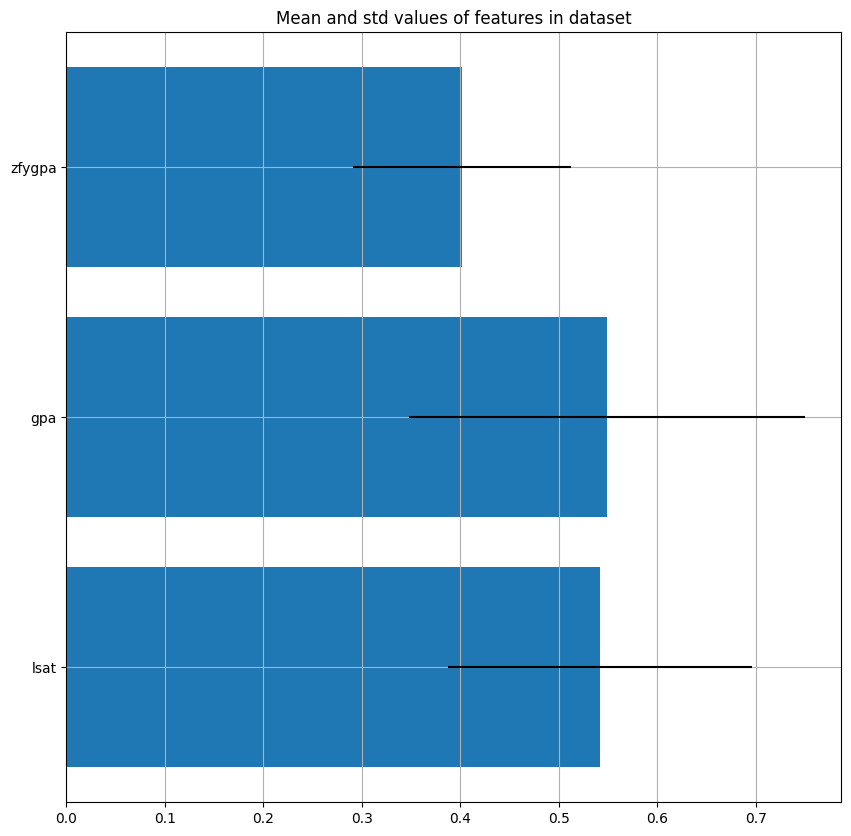

In [81]:
# plot barplot with mean and std of each feature
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
mean = Xs_filtered.mean(axis=0)
std = Xs_filtered.std(axis=0)
ax.barh(cols, mean, xerr=std, align="center")
plt.title("Mean and std values of features in dataset")
# plt.tight_layout()
plt.grid()

|    |     lsat |       gpa |   zfygpa |
|---:|---------:|----------:|---------:|
|  0 | 0.152171 | 0.172159  | 0.194832 |
|  1 | 0.147599 | 0.0291718 | 0.23229  |
|  2 | 0.21011  | 0.0889387 | 0.218168 |


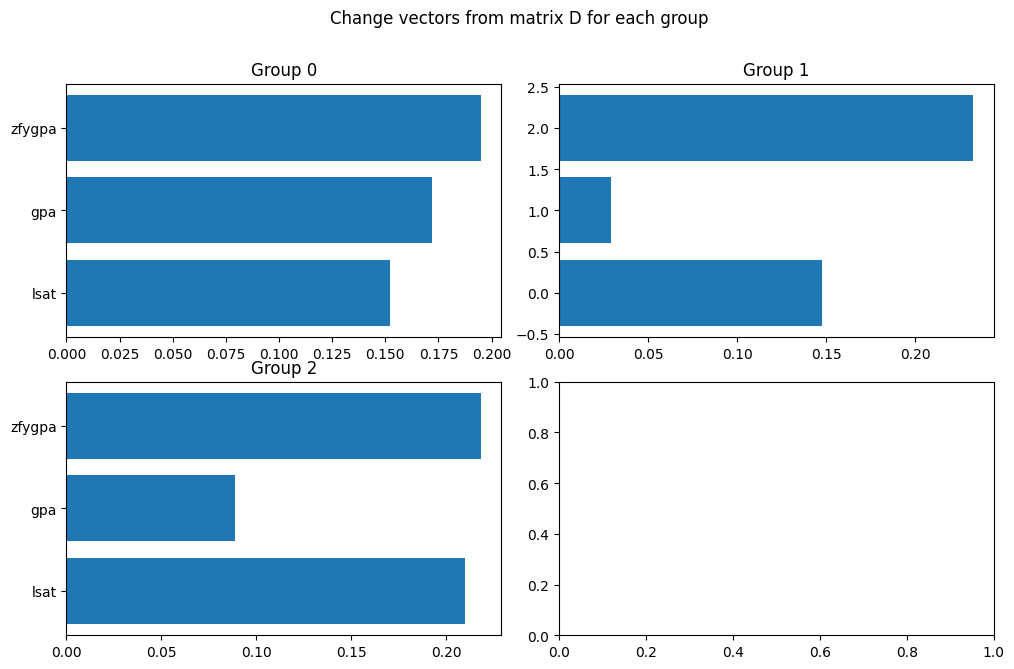

In [112]:
# plot barplot with mean and std of each feature
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle("Change vectors from matrix D for each group")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for i in range(0, 2):
    for j in range(0, 2):
        group = i * 2 + j
        if group == 3:
            break
        ax[i, j].barh(cols if j == 0 else range(len(cols)), D[group], align="center")
        ax[i, j].set_title(f"Group {group}")

# print table with mean and std of each feature
print(
    pd.DataFrame(
        [D[0], D[1], D[2]],
        columns=cols,
    ).to_markdown()
)
# pd.DataFrame(
#     np.concatenate(
#         [
#             Xs_filtered.mean(axis=0).reshape(1, -1),
#             Xs_filtered.std(axis=0).reshape(1, -1),
#         ]
#     ),
#     index=cols,
#     columns=["mean", "std"],
# ).to_markdown()

In [109]:
D.shape

(3, 3)

In [ ]:
# LSAT score received by the student.
# A student's overall GPA.
# The first year law school GPA.

In [117]:
Xs_filtered[group_labels == 0].mean()

array([[0.7297297 , 0.6666667 , 0.37310925],
       [0.5945946 , 0.47619048, 0.5361345 ],
       [0.8378378 , 0.7619048 , 0.3882353 ],
       [0.4189189 , 0.6666667 , 0.45882353],
       [0.6486486 , 0.23809524, 0.27563027],
       [0.6756757 , 0.33333334, 0.3277311 ],
       [0.7297297 , 0.9047619 , 0.40168068],
       [0.6486486 , 0.61904764, 0.42352942],
       [0.6756757 , 0.6666667 , 0.38655463],
       [0.7297297 , 0.47619048, 0.45210084],
       [0.4054054 , 0.71428573, 0.52100843],
       [0.7027027 , 0.52380955, 0.50252104],
       [0.5675676 , 0.23809524, 0.37983194],
       [0.7567568 , 0.52380955, 0.43865547],
       [0.45945945, 0.42857143, 0.4907563 ],
       [0.43243244, 0.3809524 , 0.39663866],
       [0.4054054 , 0.52380955, 0.34285715],
       [0.8918919 , 0.42857143, 0.3512605 ],
       [0.7837838 , 0.6666667 , 0.4302521 ],
       [0.7027027 , 0.61904764, 0.42857143],
       [0.3783784 , 0.52380955, 0.46554622],
       [0.6216216 , 0.71428573, 0.35462186],
       [0.

In [125]:
# Reformulating the DataFrame to have features as columns with mean ± std
mean_std_df_refined = pd.DataFrame(
    {
        "Feature 1": [
            f"{Xs_filtered[group_labels == 0][:, 0].mean():.2f} ± {Xs_filtered[group_labels == 0][:, 0].std():.2f}",
            f"{Xs_filtered[group_labels == 1][:, 0].mean():.2f} ± {Xs_filtered[group_labels == 1][:, 0].std():.2f}",
            f"{Xs_filtered[group_labels == 2][:, 0].mean():.2f} ± {Xs_filtered[group_labels == 2][:, 0].std():.2f}",
        ],
        "Feature 2": [
            f"{Xs_filtered[group_labels == 0][:, 1].mean():.2f} ± {Xs_filtered[group_labels == 0][:, 1].std():.2f}",
            f"{Xs_filtered[group_labels == 1][:, 1].mean():.2f} ± {Xs_filtered[group_labels == 1][:, 1].std():.2f}",
            f"{Xs_filtered[group_labels == 2][:, 1].mean():.2f} ± {Xs_filtered[group_labels == 2][:, 1].std():.2f}",
        ],
        "Feature 3": [
            f"{Xs_filtered[group_labels == 0][:, 2].mean():.2f} ± {Xs_filtered[group_labels == 0][:, 2].std():.2f}",
            f"{Xs_filtered[group_labels == 1][:, 2].mean():.2f} ± {Xs_filtered[group_labels == 1][:, 2].std():.2f}",
            f"{Xs_filtered[group_labels == 2][:, 2].mean():.2f} ± {Xs_filtered[group_labels == 2][:, 2].std():.2f}",
        ],
    },
    index=["Group 0", "Group 1", "Group 2"],
)

print(mean_std_df_refined.to_markdown(floatfmt=".2f"))

|         | Feature 1   | Feature 2   | Feature 3   |
|:--------|:------------|:------------|:------------|
| Group 0 | 0.58 ± 0.16 | 0.53 ± 0.18 | 0.42 ± 0.11 |
| Group 1 | 0.55 ± 0.13 | 0.58 ± 0.22 | 0.41 ± 0.11 |
| Group 2 | 0.49 ± 0.16 | 0.55 ± 0.21 | 0.38 ± 0.11 |


/var/folders/zx/yxz7rcp937j5xxx6svjlpc180000gn/T/ipykernel_20581/3620709795.py:7: RuntimeWarning: Mean of empty slice.
  mean = Xs_filtered[group_labels == group].mean(axis=0)


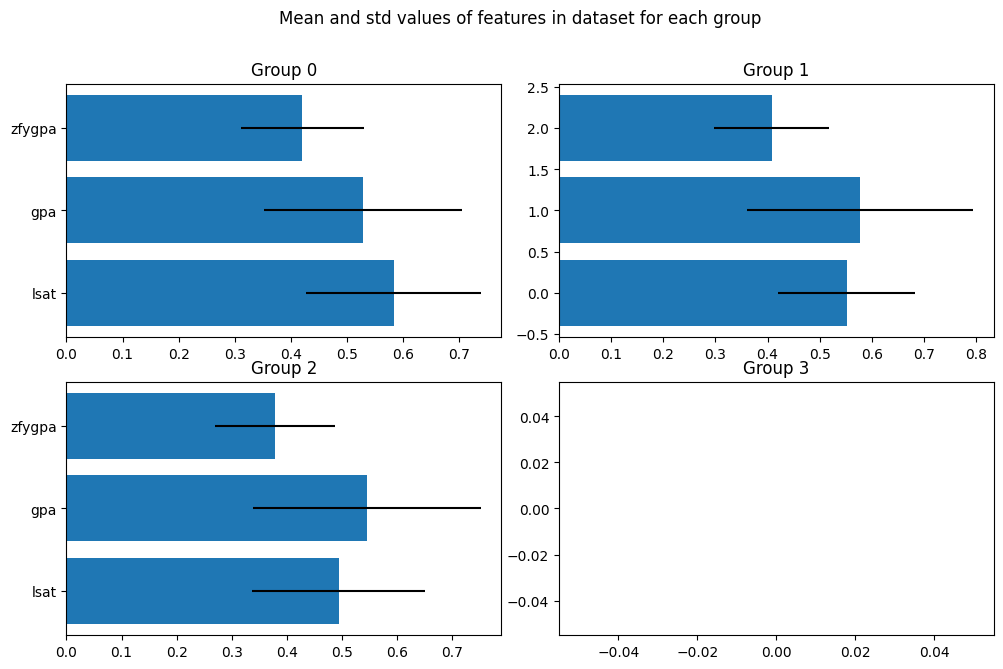

In [101]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle("Mean and std values of features in dataset for each group")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for i in range(0, 2):
    for j in range(0, 2):
        group = i * 2 + j
        mean = Xs_filtered[group_labels == group].mean(axis=0)
        std = np.abs(Xs_filtered[group_labels == group].std(axis=0))
        ax[i, j].barh(
            cols if j == 0 else range(len(cols)), mean, xerr=std, align="center"
        )
        ax[i, j].set_title(f"Group {group}")


print(
    pd.DataFrame(
        [D[0], D[1], D[2]],
        columns=cols,
    ).to_markdown()
)

In [84]:
# fig, ax = plt.subplots(3, 2, figsize=(20, 25))
# for i in range(0, 3):
#     for j in range(0, 2):
#         group = i * 2 + j
#         mean = Xs_filtered[group_labels == group].mean(axis=0) - Xs_filtered.mean(axis=0)
#         mean = Xs_filtered[group_labels == group].mean(axis=0) - Xs_filtered.mean(axis=0)
#         ax[i, j].barh(cols if j == 0 else range(len(cols)), mean, xerr=std, align="center")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

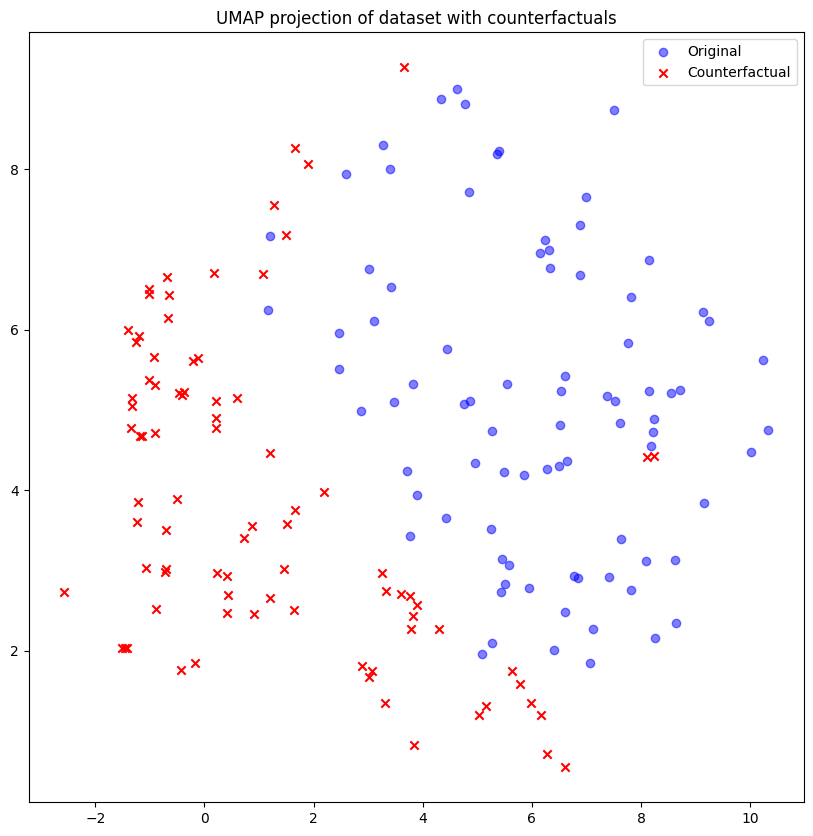

In [85]:
# plot umap dataset with group labels
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("UMAP projection of dataset with counterfactuals")
colors = ["red", "blue", "green", "yellow", "purple", "orange"]
for i, color in enumerate(colors):
    ax.scatter(
        Xs_filtered_umap[group_labels == i, 0],
        Xs_filtered_umap[group_labels == i, 1],
        c="blue",
        label="Original",
        alpha=0.5,
    )
    ax.scatter(
        X_cf_filtered_umap[group_labels == i, 0],
        X_cf_filtered_umap[group_labels == i, 1],
        c="red",
        marker="x",
        label="Counterfactual",
    )
    ax.legend(["Original", "Counterfactual"])
    ax.arrow(
        Xs_filtered_umap[group_labels == i, 0],
        Xs_filtered_umap[group_labels == i, 1],
        X_cf_filtered_umap[group_labels == i, 0]
        - Xs_filtered_umap[group_labels == i, 0],
        X_cf_filtered_umap[group_labels == i, 1]
        - Xs_filtered_umap[group_labels == i, 1],
        head_width=0.1,
        head_length=0.1,
        fc="k",
        ec="k",
        alpha=0.1,
    )
    # ax.arrow(
    #     Xs_filtered_umap[:, 0],
    #     Xs_filtered_umap[:, 1],
    #     X_cf_filtered_umap[:, 0] - Xs_filtered_umap[:, 0],
    #     X_cf_filtered_umap[:, 1] - Xs_filtered_umap[:, 1],
    #     head_width=0.1,
    #     head_length=0.1,
    #     fc="k",
    #     ec="k",
    #     alpha=0.1,
    # )

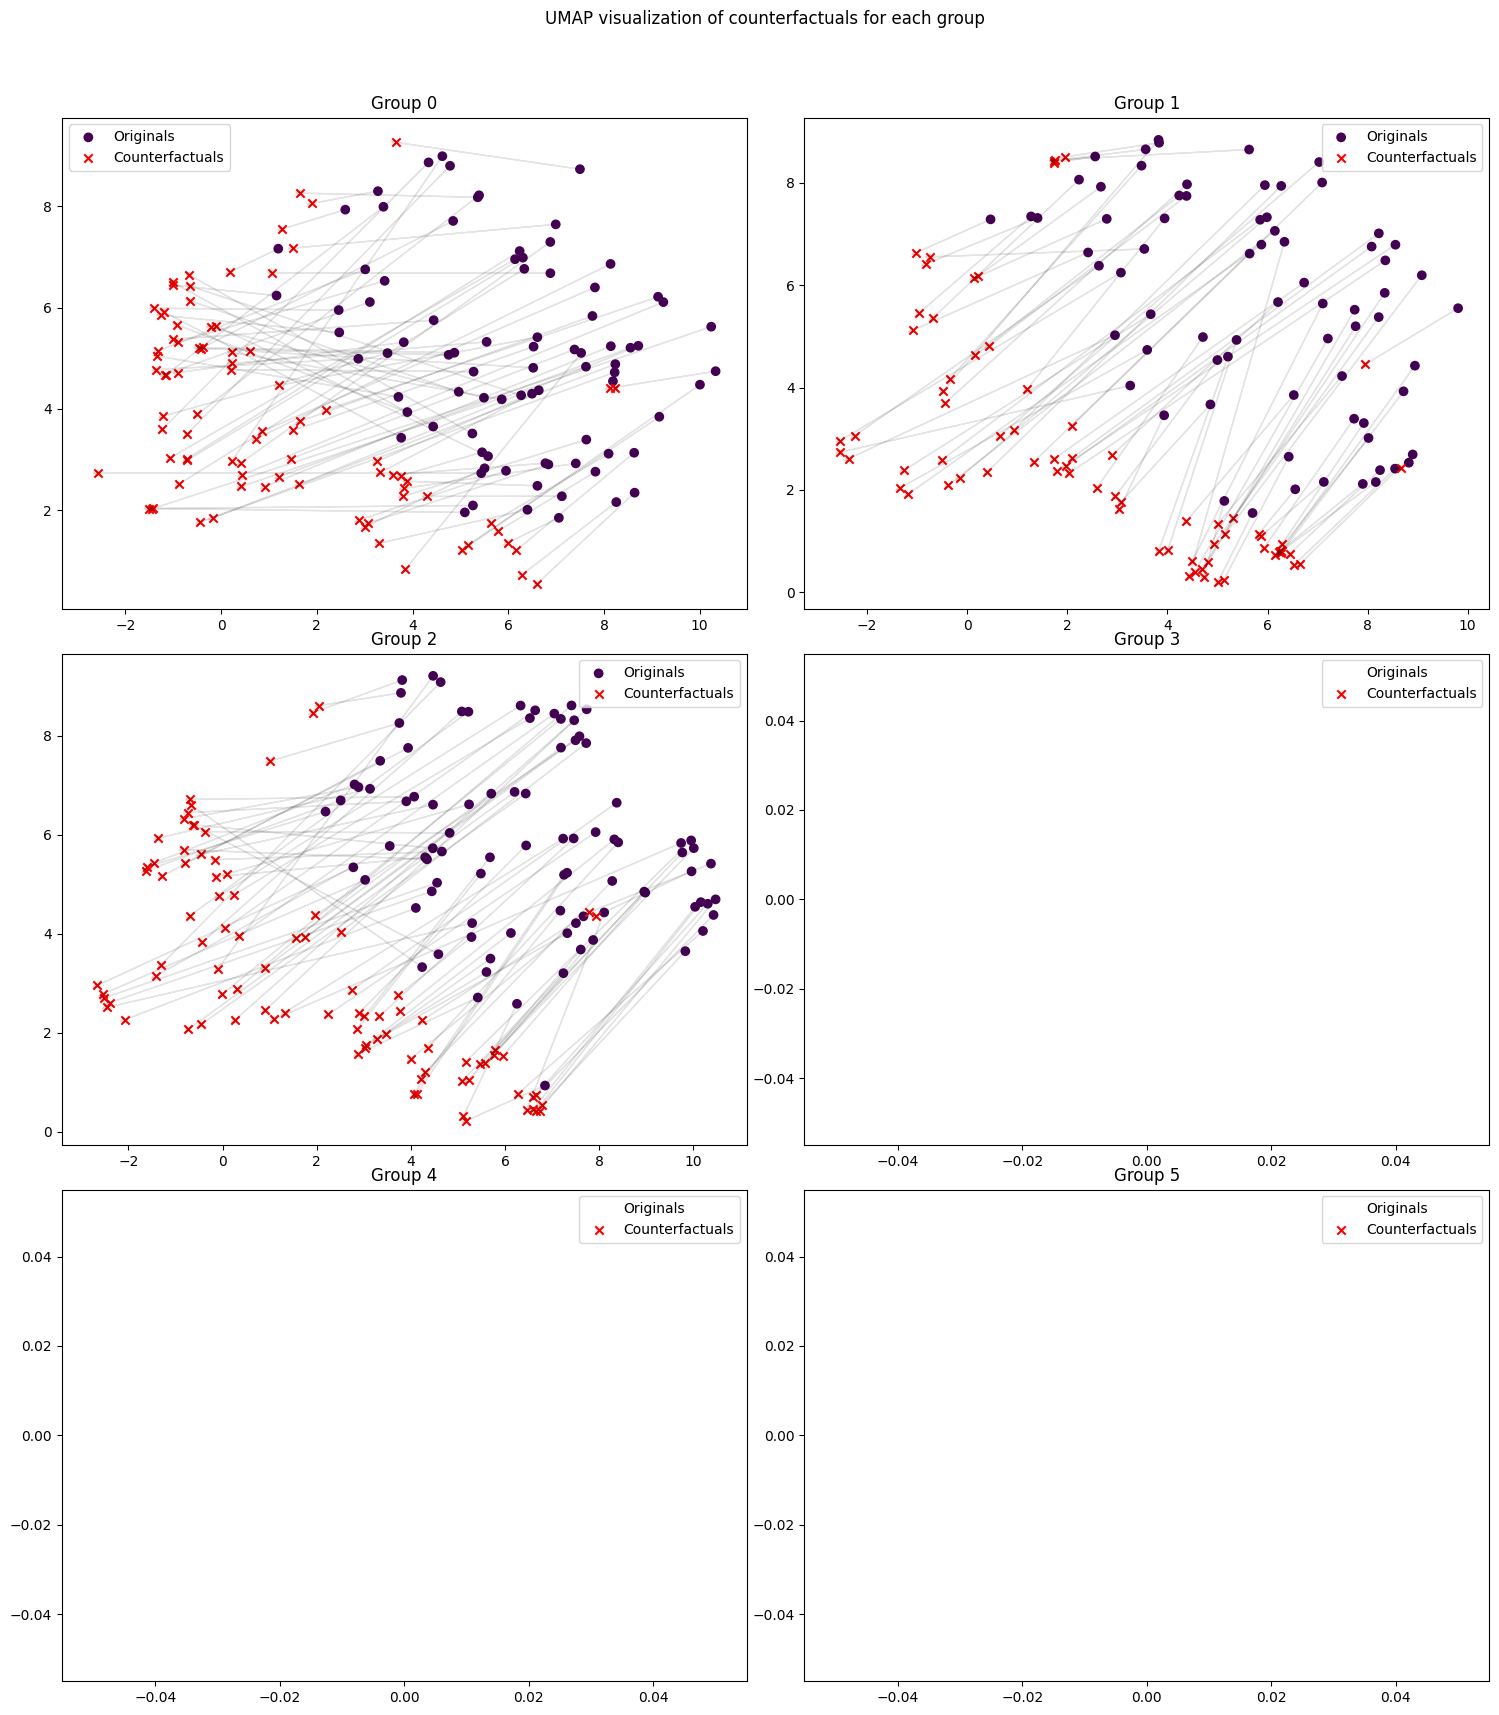

In [86]:
fig, ax = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle("UMAP visualization of counterfactuals for each group")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for i in range(0, 3):
    for j in range(0, 2):
        group = i * 2 + j
        ax[i, j].scatter(
            Xs_filtered_umap[group_labels == group, 0],
            Xs_filtered_umap[group_labels == group, 1],
            c=group_labels[group_labels == group],
            label="Originals",
        )
        ax[i, j].scatter(
            X_cf_filtered_umap[group_labels == group, 0],
            X_cf_filtered_umap[group_labels == group, 1],
            c="red",
            marker="x",
            label="Counterfactuals",
        )
        ax[i, j].legend(loc="best")
        ax[i, j].set_title(f"Group {group}")
        # add arrows from Xs to X_cf
        for k in range(Xs_filtered[group_labels == group].shape[0]):
            ax[i, j].arrow(
                Xs_filtered_umap[group_labels == group][k, 0],
                Xs_filtered_umap[group_labels == group][k, 1],
                X_cf_filtered_umap[group_labels == group][k, 0]
                - Xs_filtered_umap[group_labels == group][k, 0],
                X_cf_filtered_umap[group_labels == group][k, 1]
                - Xs_filtered_umap[group_labels == group][k, 1],
                head_width=0.1,
                head_length=0.1,
                fc="k",
                ec="k",
                alpha=0.1,
            )

(3, 2)


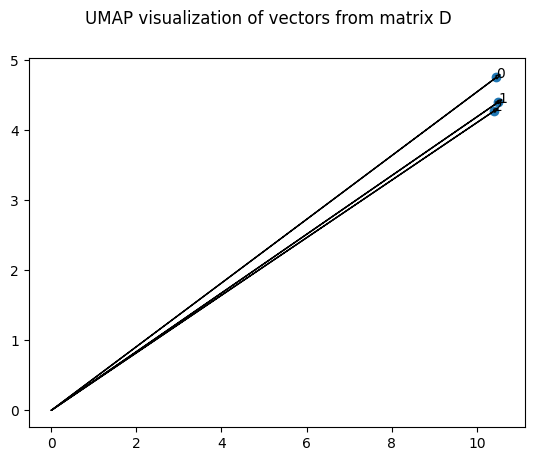

In [87]:
# plot vectors from D matrix as arrows in 2D space alongside with index of the vector
D_umap = umap.transform(D)
print(D_umap.shape)

fig, ax = plt.subplots(1, 1)
fig.suptitle("UMAP visualization of vectors from matrix D")
ax.scatter(D_umap[:, 0], D_umap[:, 1])
for i, txt in enumerate(range(D.shape[0])):
    ax.annotate(txt, (D_umap[i, 0], D_umap[i, 1]))

for i in range(D.shape[0]):
    ax.arrow(0, 0, D_umap[i, 0], D_umap[i, 1], head_width=0.05, head_length=0.1)

plt.show()

Text(0.5, 0, 'Magnitude')

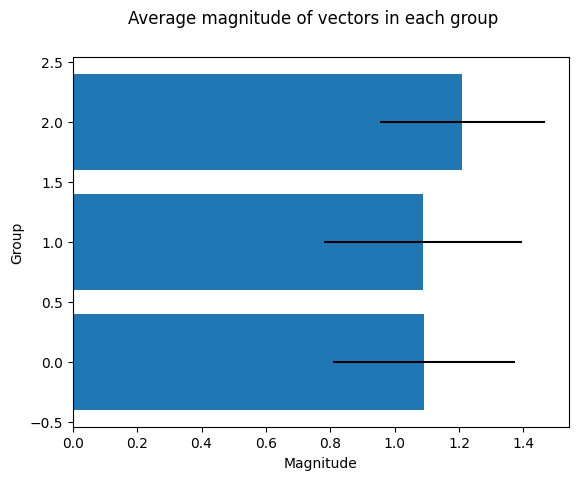

In [88]:
mean_magnitudes = []
std_magnitudes = []
for label in np.unique(group_labels):
    mean_magnitudes.append(M.flatten()[filters][group_labels == label].mean())
    std_magnitudes.append(M.flatten()[filters][group_labels == label].std())

fig, ax = plt.subplots(1, 1)
fig.suptitle("Average magnitude of vectors in each group")
ax.barh(np.unique(group_labels), mean_magnitudes, xerr=std_magnitudes)
ax.set_ylabel("Group")
ax.set_xlabel("Magnitude")

In [ ]:
#

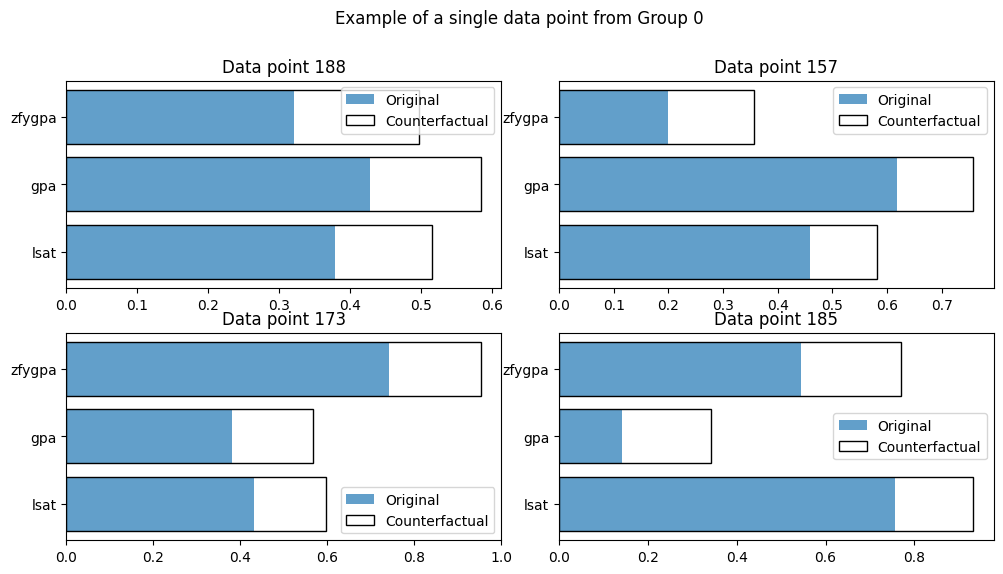

In [102]:
# data_idx = 24

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# plt.title(f"Example of a single data point from Group {group_labels[data_idx]}")
# ax.barh(cols, Xs_filtered[data_idx], alpha=0.7, label="Original")
# ax.barh(cols, Xs_filtered[data_idx] + D[group_labels[data_idx]] * M[data_idx], color="none", edgecolor = "black", label="Counterfactual")
# plt.legend()
# plt.tight_layout()

# plot 4 subplots of original and counterfactuals feature values for group 0 for random data points
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Example of a single data point from Group 0")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for i in range(0, 2):
    for j in range(0, 2):
        data_idx = np.random.choice(np.where(group_labels == 0)[0])
        ax[i, j].barh(cols, Xs_filtered[data_idx], alpha=0.7, label="Original")
        ax[i, j].barh(
            cols,
            Xs_filtered[data_idx] + D[group_labels[data_idx]] * M[data_idx],
            color="none",
            edgecolor="black",
            label="Counterfactual",
        )
        ax[i, j].set_title(f"Data point {data_idx}")
        ax[i, j].legend()

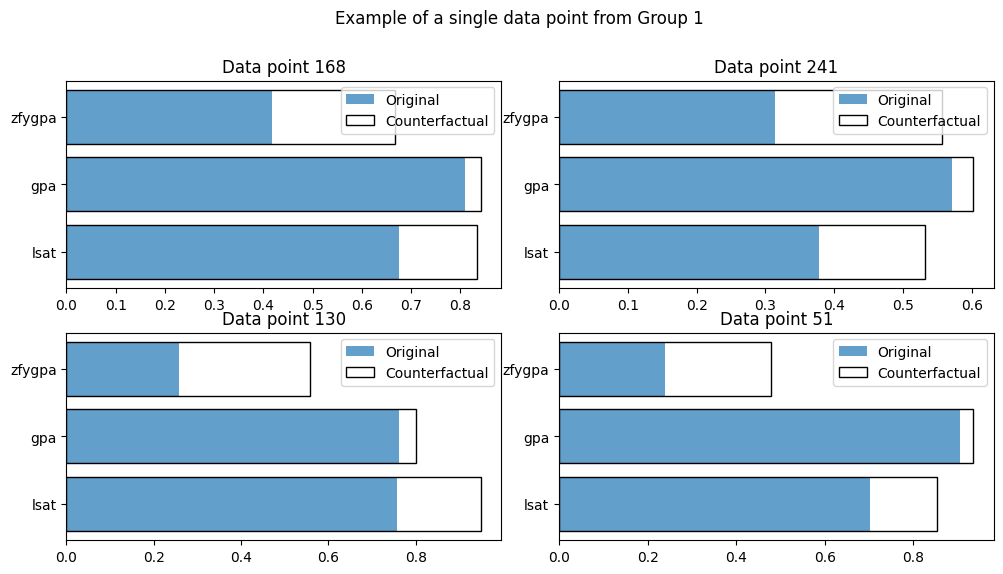

In [103]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Example of a single data point from Group 1")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for i in range(0, 2):
    for j in range(0, 2):
        data_idx = np.random.choice(np.where(group_labels == 1)[0])
        ax[i, j].barh(cols, Xs_filtered[data_idx], alpha=0.7, label="Original")
        ax[i, j].barh(
            cols,
            Xs_filtered[data_idx] + D[group_labels[data_idx]] * M[data_idx],
            color="none",
            edgecolor="black",
            label="Counterfactual",
        )
        ax[i, j].set_title(f"Data point {data_idx}")
        ax[i, j].legend()

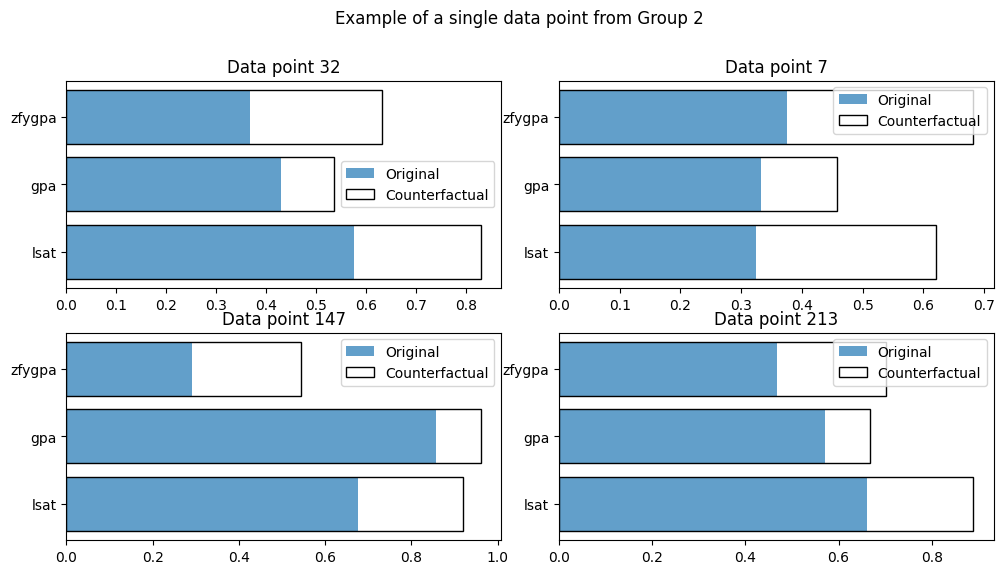

In [104]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Example of a single data point from Group 2")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for i in range(0, 2):
    for j in range(0, 2):
        data_idx = np.random.choice(np.where(group_labels == 2)[0])
        ax[i, j].barh(cols, Xs_filtered[data_idx], alpha=0.7, label="Original")
        ax[i, j].barh(
            cols,
            Xs_filtered[data_idx] + D[group_labels[data_idx]] * M[data_idx],
            color="none",
            edgecolor="black",
            label="Counterfactual",
        )
        ax[i, j].set_title(f"Data point {data_idx}")
        ax[i, j].legend()